## Aluno
**Nome**: Orlando José da Cunha Palmeira <br>
**Número:** PG54123 <br>
**Curso:** Mestrado em Engenharia Informática

## Inicialização

Instalação do Z3

In [ ]:
pip install z3-solver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 10.8 MB/s eta 0:00:00


Importar o solver

In [ ]:
from z3 import *

## Exercício
Pretende-se colorir uma sequência de 9 azulejos justapostos com uma paleta de 4 cores: azul, verde, cinzento e preto. A coloração dos azulejos tem que ser feita de acordo com as seguintes regras:
1. Cada azulejo tem uma única cor.
2. Os azulejos das extremidades têm que ter a mesma cor.
3. Todas as cores têm que ser usadas.
4. O azulejo do meio só pode ser pintado de cinzento ou preto.
5. O penúltimo azulejo da sequência tem que ser preto, excepto se o último estiver pintado de preto.
6. Azulejos seguidos não podem ser pintados da mesma cor.
7. Caso o primeiro azulejo seja verde e o terceiro não seja preto, o segundo terá que ser cinzento ou preto.
8. Os azulejos na terceira e na sétima posição só podem ser pintados de azul ou de verde.

Pretende-se codificar este problema em lógica proposicional e usar o Z3 para responder a algumas questões.

### 1 Codifique o problema num solver e comprove que o conjunto de fórmulas é consistente

#### 1.1 Codificação do problema

In [ ]:
# Nomes das cores
azul = "azul"
verde = "verde"
cinzento = "cinzento"
preto = "preto"

# Variáveis
azulejos = [1,2,3,4,5,6,7,8,9]
cores = [azul, verde, cinzento, preto]
x = {} # Xa,c -> Variável que indica que o azulejo "a" tem a cor "c".

for azulejo in azulejos:
    x[azulejo] = {}
    for cor in cores:
        x[azulejo][cor] = Bool("%d,%s" % (azulejo,cor))

solver = Solver()

# Restrições do problema
## 0. Todos os azulejos têm pelo menos 1 cor (não mencionado no enunciado)
for azulejo in azulejos:
    solver.add(Or([x[azulejo][cor] for cor in cores]))

## 1. Cada azulejo tem uma única cor.
for azulejo in azulejos:
    solver.add(Implies(x[azulejo][azul],     Not(Or([x[azulejo][cor] for cor in [verde, cinzento, preto]])))) # Xa,azul -> ~ (Xa,verde v Xa,cinzento v Xa,preto)
    solver.add(Implies(x[azulejo][verde],    Not(Or([x[azulejo][cor] for cor in [azul, cinzento, preto]]))))
    solver.add(Implies(x[azulejo][cinzento], Not(Or([x[azulejo][cor] for cor in [verde, azul, preto]]))))
    solver.add(Implies(x[azulejo][preto],    Not(Or([x[azulejo][cor] for cor in [verde, cinzento, azul]]))))

## 2. Os azulejos das extremidades (1 e 9) têm que ter a mesma cor.
for cor in cores:
    # para cada cor c: X1,c <=> X9,c
    solver.add(And(Implies(x[1][cor],x[9][cor]), Implies(x[9][cor],x[1][cor])))

## 3. Todas as cores têm que ser usadas.
for cor in cores:
    solver.add(Or([x[azulejo][cor] for azulejo in azulejos])) # para cada cor c: x1,c v x2,c v ... v x9,c

## 4. O azulejo do meio (5) só pode ser pintado de cinzento ou preto.
solver.add(And(Or(x[5][cinzento],x[5][preto]), Not(Or(x[5][verde],x[5][azul])))) # (X5,cinzento v X5,preto) ^ ~(X5,verde v X5,azul)

## 5. O penúltimo azulejo da sequência tem que ser preto, excepto se o último estiver pintado de preto. (se o último não for preto, então o penúltimo é preto)
solver.add(Implies(Not(x[9][preto]), x[8][preto])) # ~x9,preto -> x8,preto

## 6. Azulejos seguidos não podem ser pintados da mesma cor.
for i in azulejos[:-1]:
    for cor in cores:
        solver.add(And(Implies(x[i][cor], Not(x[i+1][cor])), Implies(x[i+1][cor], Not(x[i][cor])))) # xi,cor -> ~xi+1,cor ^ xi+1,cor -> ~xi,cor


## 7. SE o primeiro azulejo for verde E o terceiro NÃO for preto, então o segundo terá que ser cinzento ou preto.
solver.add(Implies(And(x[1][verde], Not(x[3][preto])), Or(x[2][cinzento], x[2][preto]))) # (x1,verde ^ ~x3,preto) -> (x2,cinzento v x2,preto)

## 8. Os azulejos na terceira e na sétima posição só podem ser pintados de azul ou de verde.
solver.add(And(Or(x[3][verde], x[3][azul]), Not(x[3][preto]), Not(x[3][cinzento]))) # (x3,verde v x3,azul) ^ ~x3,preto ^ ~x3,cinzento
solver.add(And(Or(x[7][verde], x[7][azul]), Not(x[7][preto]), Not(x[7][cinzento]))) # (x7,verde v x7,azul) ^ ~x7,preto ^ ~x7,cinzento

#### 1.2 Prova de que o conjunto de fórmulas é consistente.

In [ ]:
if solver.check():
    print(f"O conjunto de fórmulas é consistente.")
else:
    print(f"O conjunto de fórmulas é inconsistente.")

O conjunto de fórmulas é consistente.


### 2 Com a ajuda do solver, pronuncie-se quanto à veracidade das seguintes afirmações:
a. Se o primeiro azulejo for preto, o penúltimo azulejo tem que ser azul. <br>
b. Algum dos dois últimos azulejos tem que ser preto. <br>
c. Algum dos três primeiros azulejos poderá ser azul.

#### 2.a Se o primeiro azulejo for preto, o penúltimo azulejo tem que ser azul.
Esta afirmação pode ser traduzida para o seguinte: $x_{1,preto} \rightarrow x_{8,azul}$. <br>
O objectivo é saber se a fórmula acima é consequência lógica do conjunto de fórmulas fornecido ao solver.
O solver não fornece nenhum mecanismo para verificar se uma fórmula é uma consequência lógica de um conjunto de fórmulas. No entanto, podemos fazer um artifício que consiste em colocar a negação da fórmula dentro do conjunto original. Assim, se o resultado dessa junção for insatisfazível, então podemos concluir que a fórmula é uma consequência lógica do conjunto de fórmulas fornecido ao solver.

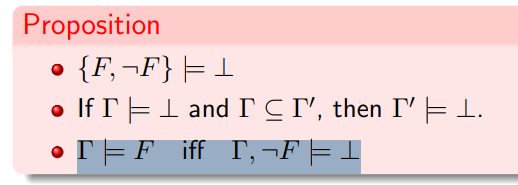

In [ ]:
solver.push()
formulaA = Implies(x[1][preto], x[8][azul]) # x1,preto -> x8,azul
notFormulaA = Not(formulaA)

solver.add(notFormulaA)

if not solver.check() == sat:
    print('A afirmação "Se o primeiro azulejo for preto, o penúltimo azulejo tem que ser azul." é verdadeira')
else:
    print('A afirmação "Se o primeiro azulejo for preto, o penúltimo azulejo tem que ser azul." é falsa')

solver.pop()

A afirmação "Se o primeiro azulejo for preto, o penúltimo azulejo tem que ser azul." é falsa


#### 2.b Algum dos dois últimos azulejos tem que ser preto.
Esta afirmação pode ser traduzida para o seguinte: $x_{8,preto} \vee x_{9,preto} $

In [ ]:
solver.push()
formulaB = Or(x[8][preto], x[9][preto])
notFormulaB = Not(formulaB)

solver.add(notFormulaB)

if not solver.check() == sat:
    print('A afirmação "Algum dos dois últimos azulejos tem que ser preto." é verdadeira')
else:
    print('A afirmação "Algum dos dois últimos azulejos tem que ser preto." é falsa')

solver.pop()

A afirmação "Algum dos dois últimos azulejos tem que ser preto." é verdadeira


#### 2.c  Algum dos três primeiros azulejos poderá ser azul.
Este caso é diferente dos dois anteriores. Aqui pretendemos saber se existe a possibilidade de algum dos três primeiros azulejos ser azul. Assim, vamos adicionar a fórmula $x_{1,azul} \vee x_{2,azul} \vee x_{3,azul}$ ao conjunto de fórmulas do solver e verificar se é satisfazível. Se for satisfazível, então é porque existe essa possibilidade.

In [ ]:
solver.push()

formulaC = Or(x[1][azul],x[2][azul],x[3][azul])
solver.add(formulaC)

if solver.check() == sat:
    print('A afirmação "Algum dos três primeiros azulejos poderá ser azul." é verdadeira')
else:
    print('A afirmação "Algum dos três primeiros azulejos poderá ser azul." é falsa')

solver.pop()

A afirmação "Algum dos três primeiros azulejos poderá ser azul." é verdadeira


### 3 Acrescente código ao programa de modo a saber todas as colorações que são possíveis fazer aos azulejos. Quantas são?

In [ ]:
solver.push()
i=0

while solver.check() == sat:
    i+=1
    m = solver.model()
    f=[]
    for a in azulejos:
        for c in cores:
            if is_true(m[x[a][c]]):
                print("Azulejo %s: %s" % (a,c))
                f.append(Not(x[a][c]))
            else:
                f.append(x[a][c])
    solver.add(Or(f))
    print()
else:
  print("Número de soluções: ", i)

solver.pop()

Azulejo 1: preto
Azulejo 2: azul
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: verde
Azulejo 7: azul
Azulejo 8: verde
Azulejo 9: preto

Azulejo 1: preto
Azulejo 2: azul
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: preto
Azulejo 7: azul
Azulejo 8: verde
Azulejo 9: preto

Azulejo 1: preto
Azulejo 2: azul
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: preto
Azulejo 7: verde
Azulejo 8: cinzento
Azulejo 9: preto

Azulejo 1: preto
Azulejo 2: azul
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: preto
Azulejo 7: azul
Azulejo 8: cinzento
Azulejo 9: preto

Azulejo 1: cinzento
Azulejo 2: azul
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: preto
Azulejo 7: azul
Azulejo 8: preto
Azulejo 9: cinzento

Azulejo 1: cinzento
Azulejo 2: preto
Azulejo 3: verde
Azulejo 4: azul
Azulejo 5: cinzento
Azulejo 6: preto
Azulejo 7: azul
Azulejo 8: preto
Azulejo 9: cinzento

Azulejo 1: cinzento
Azulejo 2: verde
Azulejo 3: azul
Azu